In [108]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from catboost import CatBoost

import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

import lightgbm as lgb
from lightgbm import LGBMRegressor



# 1. Data preparation

In [109]:
data = pd.read_csv('/datasets/car_data.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Mileage              354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


Let's determine the data that we need to train the model.

Firstly, **our target will be the 'Price' column**.

And we'll need to determine what to exclude from our features.
1. **'DateCrawled'** provides no value in training our ML model
2. **'Price'** is our target, so that is excluded
3. **'DateCreated'** also doesn't provide value
4. **'LastSeen'** should not have an impact on the training of our model
5. **'PostalCode'** provides little value in training our model
6. **'NumberOfPictures'** is useless.

Let's see if there is anything else that we can do to improve our ML model.
1. **'VehicleType'** is categorical. It might be detrimental to fill null values with a default value so we'll leave it
2. **'RegistrationYear'** is a continuous interval variable. Doing OHE in this column works, but it's unecessary.
3. **'Gearbox'** is categorical. There are null values, but we probably shouldn't assume a type.
4. **'Power'** is numerical. 
5. **'Model'** is categorical. Also has null values, but we shouldn't fill these either.
6. **'Mileage'** is numerical.
6. **'RegistrationMonth'** is also categorical
7. **'FuelType'** is categorical. Let's not fill the null values
8. **'Brand'** is categorical
9. **'NotRepaired'** is categorical.

In [110]:
#check column
data['RegistrationYear'].value_counts()

2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
3200        1
1920        1
1919        1
1915        1
8455        1
Name: RegistrationYear, Length: 151, dtype: int64

We have some ridiculous years that may affect our training data, so we'll remove these.

In [111]:
data = data.loc[(data['RegistrationYear']>1900) & (data['RegistrationYear']<2020)]
data.shape[0]

354198

In [112]:
#specify categories
categorical = ['VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired']

In [113]:
#drop unecessary columns from features
features = data.drop(['DateCrawled', 'Price', 'DateCreated', 'LastSeen', 'PostalCode', 'NumberOfPictures'], axis=1)

#get target
target = data['Price']

In [114]:
#fill null values. Only categorical variables have null values, so we'll just fill them all with NaN strings.
features = features.fillna('NaN')

features.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 354198 entries, 0 to 354368
Data columns (total 10 columns):
VehicleType          354198 non-null object
RegistrationYear     354198 non-null int64
Gearbox              354198 non-null object
Power                354198 non-null int64
Model                354198 non-null object
Mileage              354198 non-null int64
RegistrationMonth    354198 non-null int64
FuelType             354198 non-null object
Brand                354198 non-null object
NotRepaired          354198 non-null object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


In [115]:
#one hot encoding for linear regression
ohe = pd.get_dummies(data = features, columns = categorical, drop_first=True)

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(ohe, target, test_size=.25, random_state=42)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25, random_state=42)

print('features_train_ohe size:', features_train_ohe.shape[0])
print('features_test_ohe size:', features_test_ohe.shape[0])
print('target_train_ohe size:', target_train_ohe.shape[0])
print('target_test_ohe size:', target_test_ohe.shape[0])
print()
print('features_train size:', features_train.shape[0])
print('features_test size:', features_test.shape[0])
print('target_train size:', target_train.shape[0])
print('target_test size:', target_test.shape[0])

features_train_ohe size: 265648
features_test_ohe size: 88550
target_train_ohe size: 265648
target_test_ohe size: 88550

features_train size: 265648
features_test size: 88550
target_train size: 265648
target_test size: 88550


In [116]:
#scale numerics
numerics = ['RegistrationYear','Power','Mileage']
#scale
scaler = StandardScaler()
scaler.fit(features_train_ohe[numerics])

features_train[numerics] = scaler.transform(features_train[numerics])
features_test[numerics] = scaler.transform(features_test[numerics])

features_train_ohe[numerics] = scaler.transform(features_train_ohe[numerics])
features_test_ohe[numerics] = scaler.transform(features_test_ohe[numerics])

# 2. Model training

We'll create a new dataframe to analyze our findings easier.

In [117]:
model_data = pd.DataFrame(columns=('model','fit_time','score_time','RMSE'))
model_data.head()

,model,fit_time,score_time,RMSE


Let's first just do a sanity check.

## Linear Regression

In [118]:
def rmse(y_true, y_predict):
    mse = mean_squared_error(y_true, y_predict)
    return mse**.5

In [119]:
#create model
model = LinearRegression()

#create dataframe row
lr_data = ['Linear Regression']

#fit model and save time
start = time.time()
model.fit(ohe_ft_train, ohe_tgt_train)
end=time.time()

#add time to row
lr_data.append(end-start)

#predict and save time
start = time.time()
prediction = model.predict(ohe_ft_valid)
end=time.time()

#add time to row
lr_data.append(end-start)

#calculate RMSE
lr_rmse = rmse(ohe_tgt_valid, prediction)

#add to row
lr_data.append(lr_rmse)

model_data.loc[len(model_data)] = lr_data
model_data.head()

,model,fit_time,score_time,RMSE
0,Linear Regression,30.164315,0.197645,2975.665582


It works, so let's now test our models.

## Random Forest

In [120]:
#create model
rf_model = RandomForestRegressor(random_state=12345, n_estimators=10)

#cross validate
cv = cross_validate(model, ohe, target, cv=3, scoring='neg_mean_squared_error')

#get results
average_fit_time = cv['fit_time'].mean()
average_score_time = cv['score_time'].mean()
RMSE = (cv['test_score'].mean()*-1)**0.5

rf_data = ['Random Forest', average_fit_time, average_score_time, RMSE]

#add to dataframe
model_data.loc[len(model_data)] = rf_data
model_data.head()

,model,fit_time,score_time,RMSE
0,Linear Regression,30.164315,0.197645,2975.665582
1,Random Forest,25.963222,0.400019,2905.821943


## LightGBM

In [121]:
import warnings
warnings.filterwarnings('ignore')

for column in categorical:
    features_train[column] = features_train[column].astype('category')
    features_valid[column] = features_valid[column].astype('category')

In [122]:
lgb = LGBMRegressor()

#create parameters for feature tuning
param = {
        'num_leaves': [10, 31],
    'learning_rate': [.01,.5],
    'max_depth': [-1,5]
}

#pass parameters necessary for cross validation
gs = GridSearchCV(estimator=lgb,param_grid=param,scoring='neg_mean_squared_error')

#fit model
lgb_model = gs.fit(X=features_train, y=target_train)
print(lgb_model.best_params_, lgb_model.best_score_)

{'learning_rate': 0.5, 'max_depth': -1, 'num_leaves': 31} -3205844.749888683


In [123]:
#get dictionary of result info
results = lgb_model.cv_results_
#get best index
best_index = lgb_model.best_index_

#get results
fit_time = results['mean_fit_time'][best_index]
score_time = results['mean_score_time'][best_index]
RMSE = (lgb_model.best_score_*-1)**0.5

lgbm_data = ['LightGBM', fit_time, score_time, RMSE]

model_data.loc[len(model_data)] = lgbm_data
model_data.head()

,model,fit_time,score_time,RMSE
0,Linear Regression,30.164315,0.197645,2975.665582
1,Random Forest,25.963222,0.400019,2905.821943
2,LightGBM,4.860213,0.837615,1790.487294


# 3. Model analysis

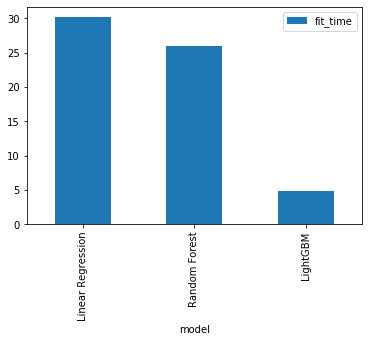

In [124]:
model_data = model_data.drop_duplicates()
model_data.plot.bar(x='model',y='fit_time')

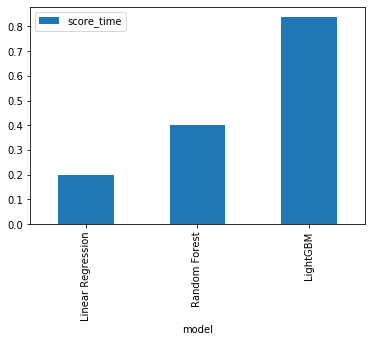

In [125]:
model_data.plot.bar(x='model',y='score_time')

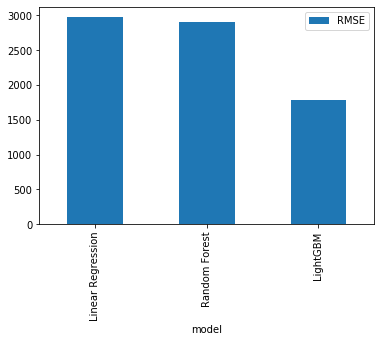

In [126]:
model_data.plot.bar(x='model',y='RMSE')

Comparatively to the random forest model, we can see that both **the speed and the quality of the model improves when we use gradient boosting**. **Linear regression** doesn not give us great results, but it helps us when doing a quick sanity check. Surprisingly, our random forest model had similar results to our linear regression model.